In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import requests

from scipy.io import mmread
from sklearn.decomposition import TruncatedSVD

/home/edusal/.conda/envs/single-cell/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


## Selecting projects

In [2]:
server_name = 'http://194.4.103.244:3030'
service_name = 'ds'
request_url = server_name + '/' + service_name

In [3]:
query = '''
PREFIX a: <http://www.semanticweb.org/alicia/ontologies/2020/8/singleCellRepositories#> 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT
    ?projectTitle
    ?repository
    ?project
    ?cellType
    (SUM(?numCells) AS ?numTotalCells)
WHERE
{
    ?specimenID rdf:type a:Specimen ;
                a:SPR.hasSpecie a:HomoSapiens ;
                a:SPR.hasMinAge ?minAge ;
                a:SPR.hasOrganismPart a:Blood ;
                a:SPR.hasProjectTitle ?projectTitle ;
                a:SPR.isPartOfRepository ?repository ;
                a:SPR.hasTotalCellCount ?numCells ;
                a:SPR.hasCellType ?cellType .
    ?projectID rdf:type a:Project ;
               a:SPR.hasProjectTitle ?projectTitle ;
               a:PR.hasProjectID ?project
    FILTER (?numCells != -1) .
    FILTER (?minAge > 17) .
}
GROUP BY ?projectTitle ?repository ?project ?cellType
ORDER BY ?numTotalCells
'''

In [4]:
response = requests.post(request_url,
       data={'query': query})

# print(response.text)

headers = response.json()["head"]["vars"]
results = response.json()["results"]

rows = []

for result in response.json()["results"]["bindings"]:
    result_dict = {}
    for header in headers:
        result_dict[header] = result[header]['value']
        
    rows.append(result_dict)

df = pd.DataFrame(rows)

df['cellType'] = df['cellType'].apply(lambda x: x.split('#')[1])

df

,projectTitle,repository,project,cellType,numTotalCells
0,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,E-MTAB-4850,CD8+AlphaBetaTcell,72
1,Single cell RNA-sequencing of PBMC derived B c...,SingleCellExpresionAtlas,E-MTAB-6386,MemoryBcell,117
2,Single cell RNA-sequencing of PBMC derived B c...,SingleCellExpresionAtlas,E-MTAB-6386,NaiveBcell,117
3,Single cell RNA-sequencing of PBMC derived B c...,SingleCellExpresionAtlas,E-MTAB-6386,Plasmablast,117
4,Single cell RNA-sequencing of PBMC derived B c...,SingleCellExpresionAtlas,E-MTAB-6386,TransitionalStageBcell,117
5,Single-cell RNAseq of Human T lymphocyte deriv...,SingleCellExpresionAtlas,E-MTAB-6379,CD8+AlphaBetaTcell,119
6,Single cell RNA seq of influenza tetramer spec...,SingleCellExpresionAtlas,E-MTAB-7606,CD8+AlphaBetaTcell,210
7,Precursors of human CD4+ cytotoxic T lymphocyt...,HumanCellAtlas,90bd6933-40c0-48d4-8d76-778c103bf545,CD8+AlphaBetaTcell,376
8,Precursors of human CD4+ cytotoxic T lymphocyt...,HumanCellAtlas,90bd6933-40c0-48d4-8d76-778c103bf545,EffectorMemoryCD8+AlphaBetaTCellTerminallyDiff...,1868
9,Immune landscape of viral- and carcinogen-deri...,SingleCellExpresionAtlas,E-GEOD-139324,Leukocyte,61675


## Get matrices

In [2]:
matrix0 = mmread('../SingleCell-Files/blood_downloads/E-MTAB-4850.aggregated_filtered_normalised_counts.mtx').transpose()
matrix1 = mmread('../SingleCell-Files/blood_downloads/E-MTAB-6386.aggregated_filtered_normalised_counts.mtx').transpose()

In [3]:
print(f'E-MTAB-4850 size: {matrix0.A.shape}')
print(f'E-GEOD-6386 size: {matrix1.A.shape}')

E-MTAB-4850 size: (63, 15912)
E-GEOD-6386 size: (117, 15545)


## Use metadata to group cells by cell type

In [4]:
def get_groups(matrix_name):
    metadata = pd.read_csv(f'https://www.ebi.ac.uk/gxa/sc/experiment/{matrix_name}/download?fileType=experiment-design&accessKey=', sep='\t')
    cell_types = metadata[['Assay', 'Sample Characteristic[cell type]']]
    cell_names = pd.read_csv(f'../SingleCell-Files/blood_downloads/{matrix_name}.aggregated_filtered_normalised_counts.mtx_cols', header=None, names=['Assay'])
    
    cell_types = pd.merge(
        cell_names,
        cell_types,
        how="inner",
        on='Assay'
    )
    
    grouped = cell_types.groupby(by='Sample Characteristic[cell type]')

    types = []

    for name, group in grouped:
        types.append({
            'name': name,
            'index': group.index
        })

    return types

In [5]:
matrix0_types = get_groups('E-MTAB-4850')

print([group['name'] for group in matrix0_types])

['CD8-Positive T-Lymphocytes']


In [6]:
matrix1_types = get_groups('E-MTAB-6386')

print([group['name'] for group in matrix1_types])

['memory B cell', 'naive B cell', 'plasmablast', 'transitional stage B cell']


## Create embedding with UMAP and get the clusters

In [7]:
reducer = umap.UMAP(random_state=2021)
embedding = reducer.fit_transform(matrix0)

for cell_type in matrix0_types:
    cell_type['embedding'] = embedding[cell_type['index']]

In [8]:
reducer = umap.UMAP(random_state=2021)
embedding = reducer.fit_transform(matrix1)

for cell_type in matrix1_types:
    cell_type['embedding'] = embedding[cell_type['index']]

### Plotting the projection

In [9]:
def plot_cells(cell_types, title):
    for cell_type in cell_types:
        embedding = cell_type['embedding']

        plt.scatter(
            embedding[:, 0],
            embedding[:, 1],
            alpha=0.5,
            label=cell_type['name']
        )

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title, fontsize=24)
    plt.legend()
    plt.show()

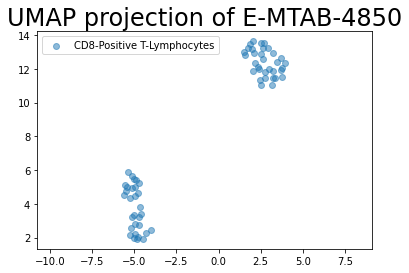

In [10]:
plot_cells(matrix0_types, 'UMAP projection of E-MTAB-4850')

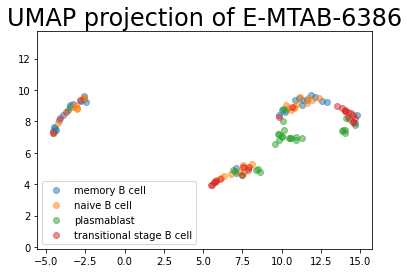

In [11]:
plot_cells(matrix1_types, 'UMAP projection of E-MTAB-6386')

## Create embedding with PCA and get the clusters

In [15]:
pca = TruncatedSVD(n_components=2)
projected = pca.fit_transform(matrix0)

for cell_type in matrix0_types:
    cell_type['embedding'] = projected[cell_type['index']]

In [16]:
pca = TruncatedSVD(n_components=2)
projected = pca.fit_transform(matrix1)

for cell_type in matrix1_types:
    cell_type['embedding'] = projected[cell_type['index']]

### Plotting the projection

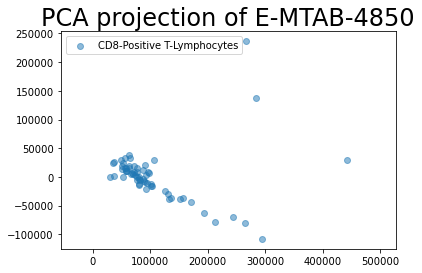

In [18]:
plot_cells(matrix0_types, 'PCA projection of E-MTAB-4850')

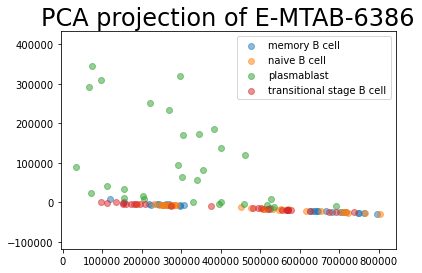

In [19]:
plot_cells(matrix1_types, 'PCA projection of E-MTAB-6386')

# Divide the matrix

In [20]:
from scipy.stats import percentileofscore

In [33]:
for group in matrix1_types:
    percentiles = []

    print(group['name'])
    submatrix = matrix1.A[group['index']]
    print(submatrix.shape)
    
    for i in range(submatrix.shape[1]):
        mean = np.mean([percentileofscore(submatrix[:,i], a, 'strict') for a in submatrix[:,i]])
        percentiles.append(mean)

    group['percentiles'] = percentiles

memory B cell
(30, 15545)
naive B cell
(30, 15545)
plasmablast
(30, 15545)
transitional stage B cell
(27, 15545)


In [43]:
gen = 199

for group in matrix1_types:
    print(f"For cell type '{group['name']}', gen {gen} is in the percentil {group['percentiles'][gen]:.2f}")

For cell type 'memory B cell', gen 199 is in the percentil 27.22
For cell type 'naive B cell', gen 199 is in the percentil 20.22
For cell type 'plasmablast', gen 199 is in the percentil 46.67
For cell type 'transitional stage B cell', gen 199 is in the percentil 19.34


# Get quantiles

In [ ]:
def get_percentiles_from_project(project_ID):
    
    print("Reading files...")
    #TODO Read project matrix and metadata
    matrix, metadata, cell_names = read_files(project_ID)
    
    
    #TODO Generate cell type groups with metadata
    cell_type_groups = get_cell_type_groups(metadata, cell_names)
    
    #TODO Get mean percentiles of each cell type
    percentiles = get_percentiles(matrix, cell_type_groups)
    
    return percentiles

In [ ]:
def read_matrix(project_ID):
    #TODO Download matrix using ontology link
    download_matrix(project_ID)
    
    # Read matrix
    matrix_file_name = f'../SingleCell-Files/blood_downloads/{project_ID}.aggregated_filtered_normalised_counts.mtx'
    matrix = mmread(matrix_file_name).transpose()
    
    # Read metadata
    metadata = pd.read_csv(f'https://www.ebi.ac.uk/gxa/sc/experiment/{matrix_name}/download?fileType=experiment-design&accessKey=', sep='\t')
    metadata = metadata[['Assay', 'Sample Characteristic[cell type]']]
    
    # Read cell names
    cells_file_name = f'../SingleCell-Files/blood_downloads/{matrix_name}.aggregated_filtered_normalised_counts.mtx_cols'
    cell_names = pd.read_csv(cells_file_name, header=None, names=['Assay'])
    
    return matrix, metadata, cell_names

In [44]:
def download_matrix(project_ID):
    return None

In [47]:
def get_cell_type_groups(metadata, cell_names):
    # Merge both dataframes so we get the cells of the matrix with their corresponding type
    cell_types = pd.merge(
        cell_names,
        metadata,
        how="inner",
        on='Assay'
    )
    
    # Group by cell type
    grouped = cell_types.groupby(by='Sample Characteristic[cell type]')

    groups = []

    # For each group, assign its name and the index of the matrix for this type
    for name, group in grouped:
        groups.append({
            'name': name,
            'index': group.index
        })

    return groups